In [1]:
import tensorflow as tf
import poisson_CNN_old as poisson_CNN
#import poisson_CNN
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

mpl.rcParams['figure.dpi']=300
warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx('float32')

img_path = '/home/ago14/storage/ali/manuscript/results/fourier_examples/'
examplename = 'fourier_hpnn_ex1'
case = 'hpnn_'

In [2]:
#Load model
mod = poisson_CNN.models.Homogeneous_Poisson_NN_Fluidnet(data_format = 'channels_first', mae_component_weight = 1e+0, mse_component_weight = 1e+1, pooling_block_number=7, n_quadpts = 47, use_deconv_upsample=True, use_batchnorm = False, initial_kernel_size=19, final_kernel_size=3, post_dx_einsum_conv_block_number=9, kernel_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4), bias_regularizer=tf.keras.regularizers.L1L2(l2 = 1e-4))
mod((tf.random.uniform((10,1,74,83), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())))
from IPython.display import clear_output
clear_output()
mod.load_weights('poisson_CNN_old/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5')

In [3]:
#Set up data generator
bsize = 10
output_shape_range = [[192,228],[192,228]]
rdxr = [0.005,0.05]
drr = [[(output_shape_range[0][0]-1)*rdxr[0],(output_shape_range[0][1]-1)*rdxr[1]],[(output_shape_range[1][0]-1)*rdxr[0],(output_shape_range[1][1]-1)*rdxr[1]]]
dg = poisson_CNN.dataset.generators.homogeneous_analytical_dataset_generator(batch_size=bsize, batches_per_epoch=50, return_dx = True, expanded_dims = True, max_magnitude = 1.0, random_output_shape_range=output_shape_range, domain_random_range=drr)


In [10]:
#Get new batch of data, use model to predict
inp,soln = dg.__getitem__(10)
pred = mod(inp)

In [11]:
#Evaluate batch error statistics
q = np.abs(pred - tf.cast(soln, tf.keras.backend.floatx()))/np.abs(tf.cast(soln, tf.keras.backend.floatx()))
rms = tf.sqrt(tf.reduce_mean((pred - tf.cast(soln, tf.keras.backend.floatx()))**2))
mae = tf.reduce_mean(tf.abs(pred - tf.cast(soln, tf.keras.backend.floatx())))
print('Mean abs % error: ' + str(100*float(tf.reduce_mean(q[q < 1]))))
print('% of gridpts with less than 10% error: ' + str(100*float(np.sum(q < 0.1)/np.prod(q.shape))))
print('RMS error: ' + str(float(rms)))
print('MAE: ' + str(float(mae)))

Mean abs % error: 21.865764260292053
% of gridpts with less than 10% error: 26.775023871798066
RMS error: 0.06720216572284698
MAE: 0.04056461527943611


Mean abs % error of sample: 14.878499507904053
dx: 0.03832903504371643
0.03161725774407387
(196, 223)


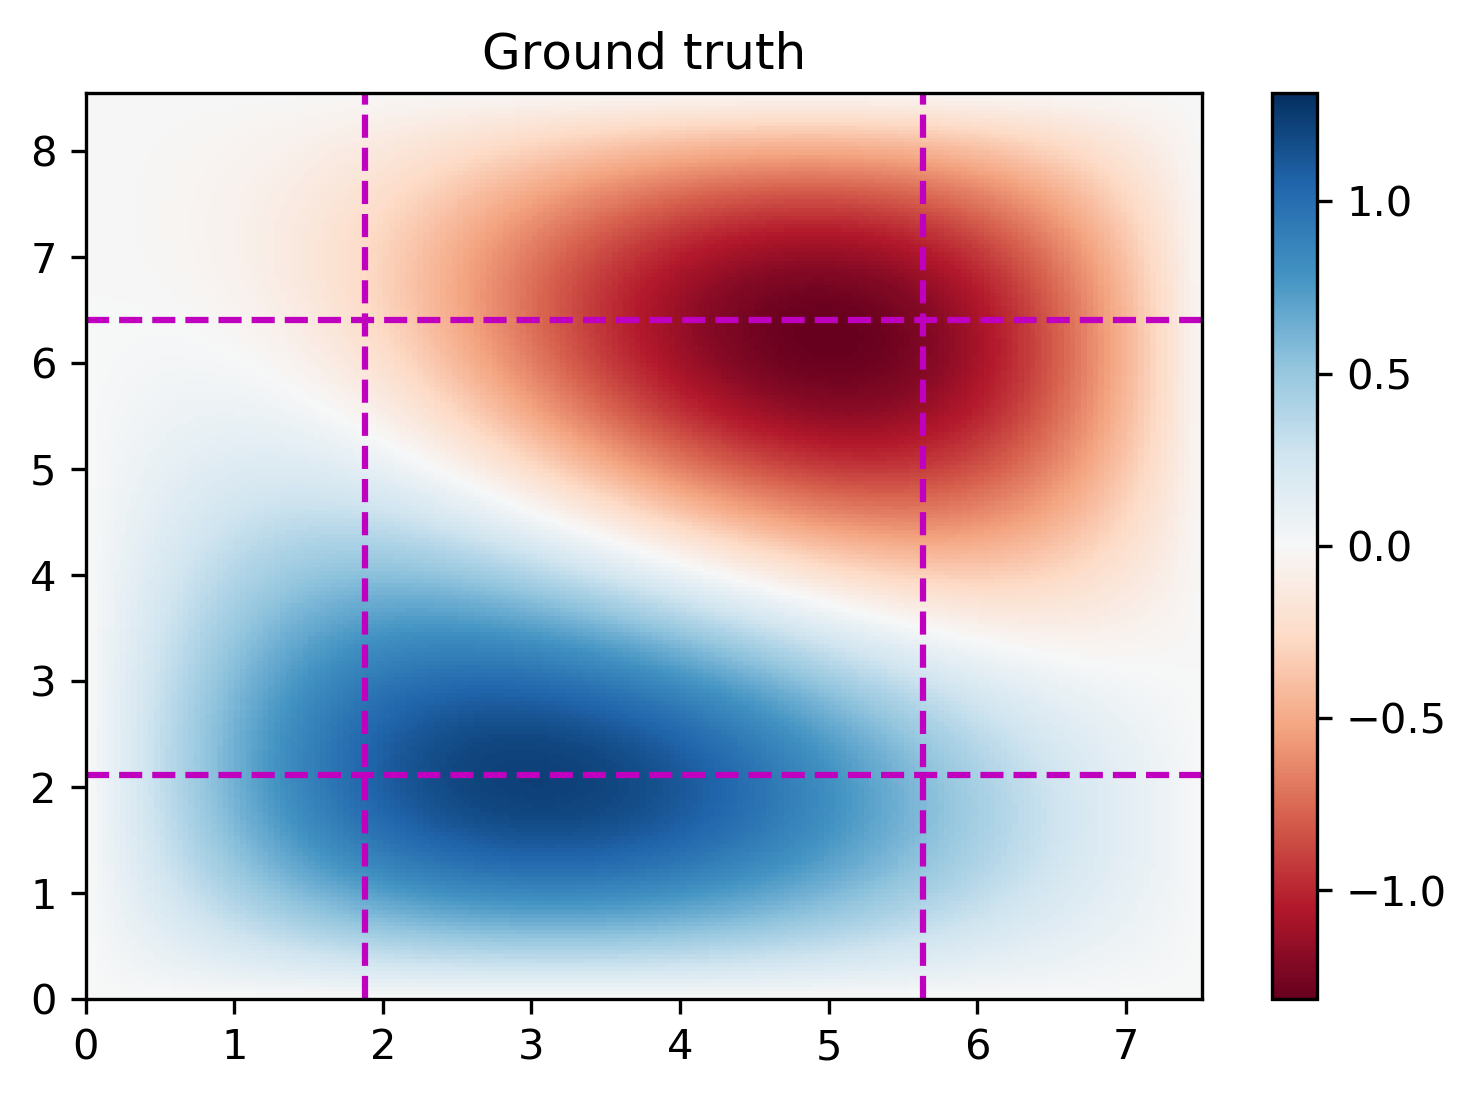

In [255]:
#Ground truth plotting
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300

saving = False

print('Mean abs % error of sample: ' + str(100*float(tf.reduce_mean(q[p_r,0,...][q[p_r,0,...] < 1]))))
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = soln[p_r,0,...]
dx = float(inp[1][p_r,0])
print('dx: ' + str(dx))
print(float(tf.reduce_mean(tf.keras.losses.mae(pred[p_r,...],tf.cast(soln[p_r,...],tf.keras.backend.floatx())))/tf.cast(tf.reduce_max(tf.abs(soln[p_r,...])),tf.keras.backend.floatx())))
print(z.shape)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Ground truth')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.axvline(x=float(inp[-1][p_r,0]*(soln.shape[-2]//4)), color = 'm', linestyle = '--')
plt.axvline(x=float(inp[-1][p_r,0]*(3*soln.shape[-2]//4)), color = 'm', linestyle = '--')
plt.axhline(y=float(inp[-1][p_r,0]*(soln.shape[-1]//4)), color = 'm', linestyle = '--')
plt.axhline(y=float(inp[-1][p_r,0]*(3*soln.shape[-1]//4)), color = 'm', linestyle = '--')

if saving:
    identifier = '_' + str(int(soln.shape[-2])) + 'x' + str(int(soln.shape[-1])) + '_dx' + ('{:.2e}'.format(dx)) + '_'
    thisimage = 'groundtruth'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

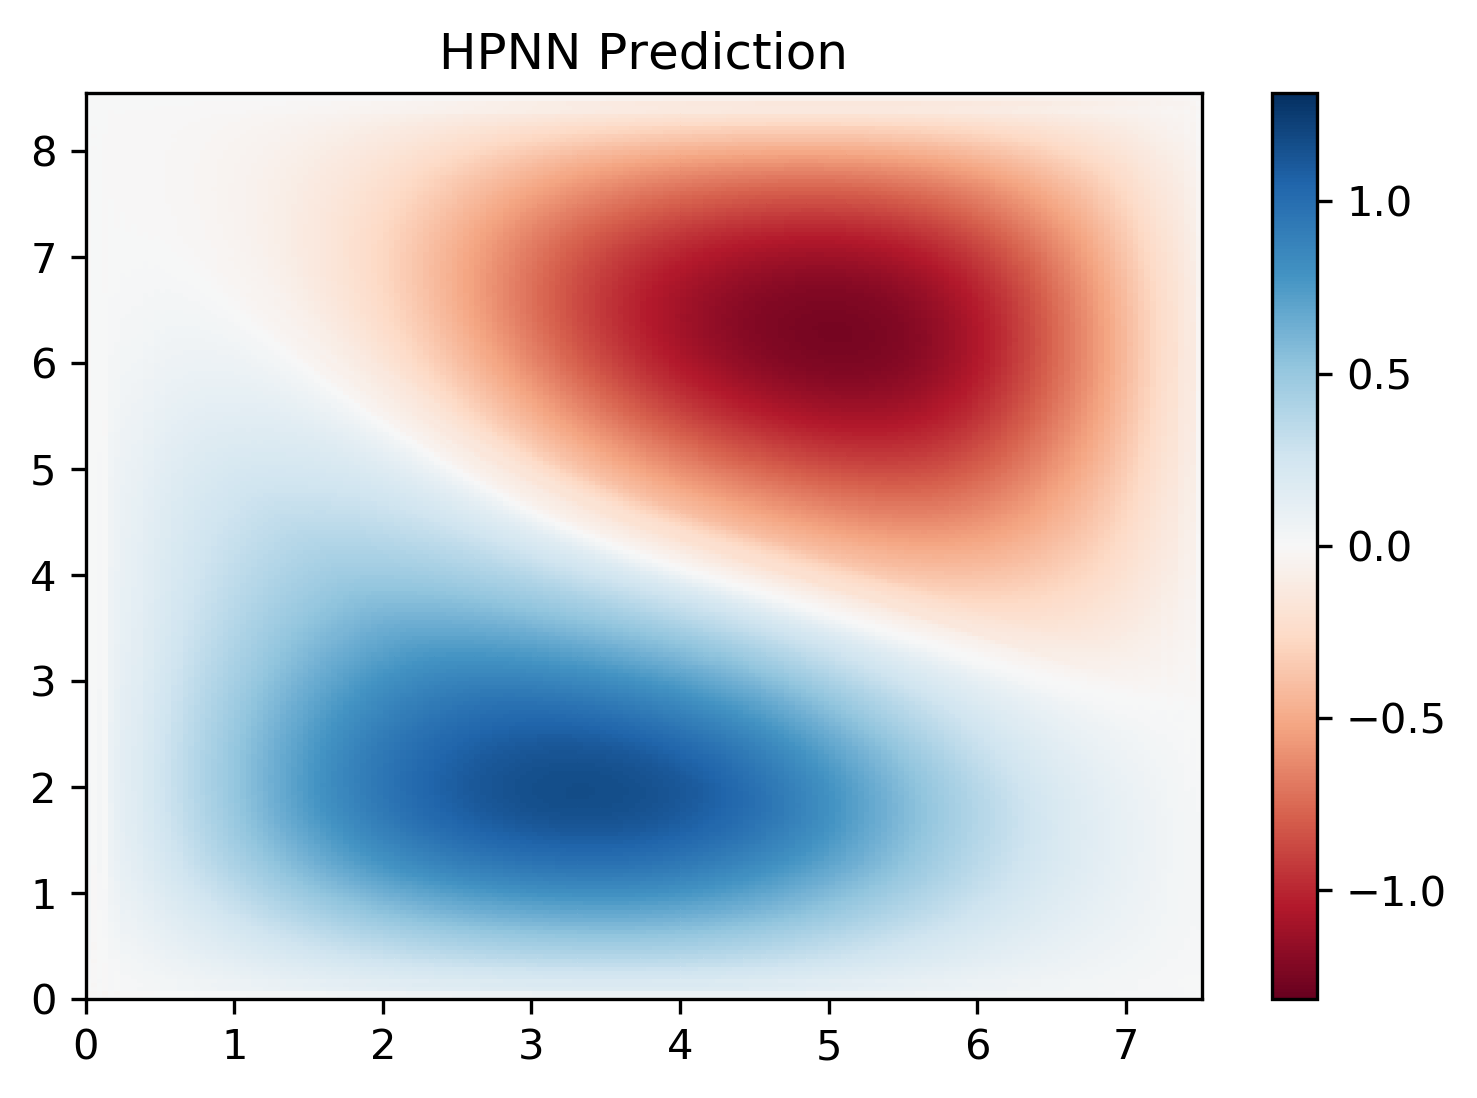

In [256]:
#Prediction plotting
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = pred[p_r,0,...]
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('HPNN Prediction')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'pred'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

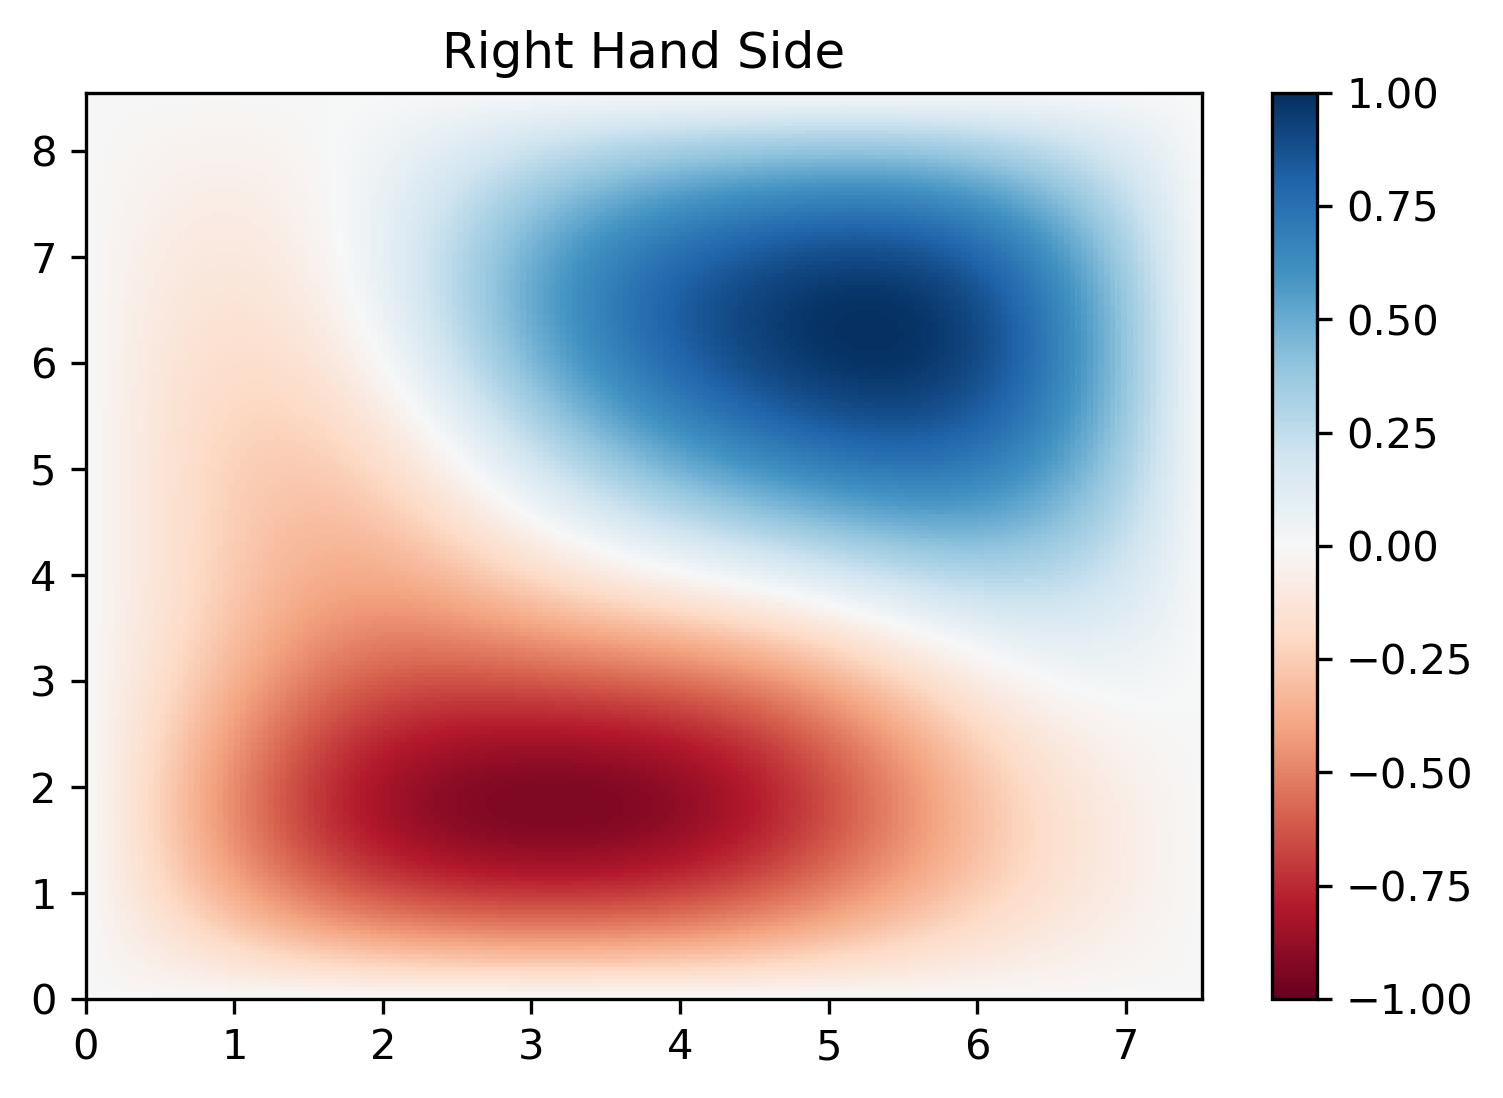

In [257]:
#RHS plotting
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = inp[0][p_r,0,...]
z_min, z_max = -1,1
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Right Hand Side')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'rhs'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(196,)


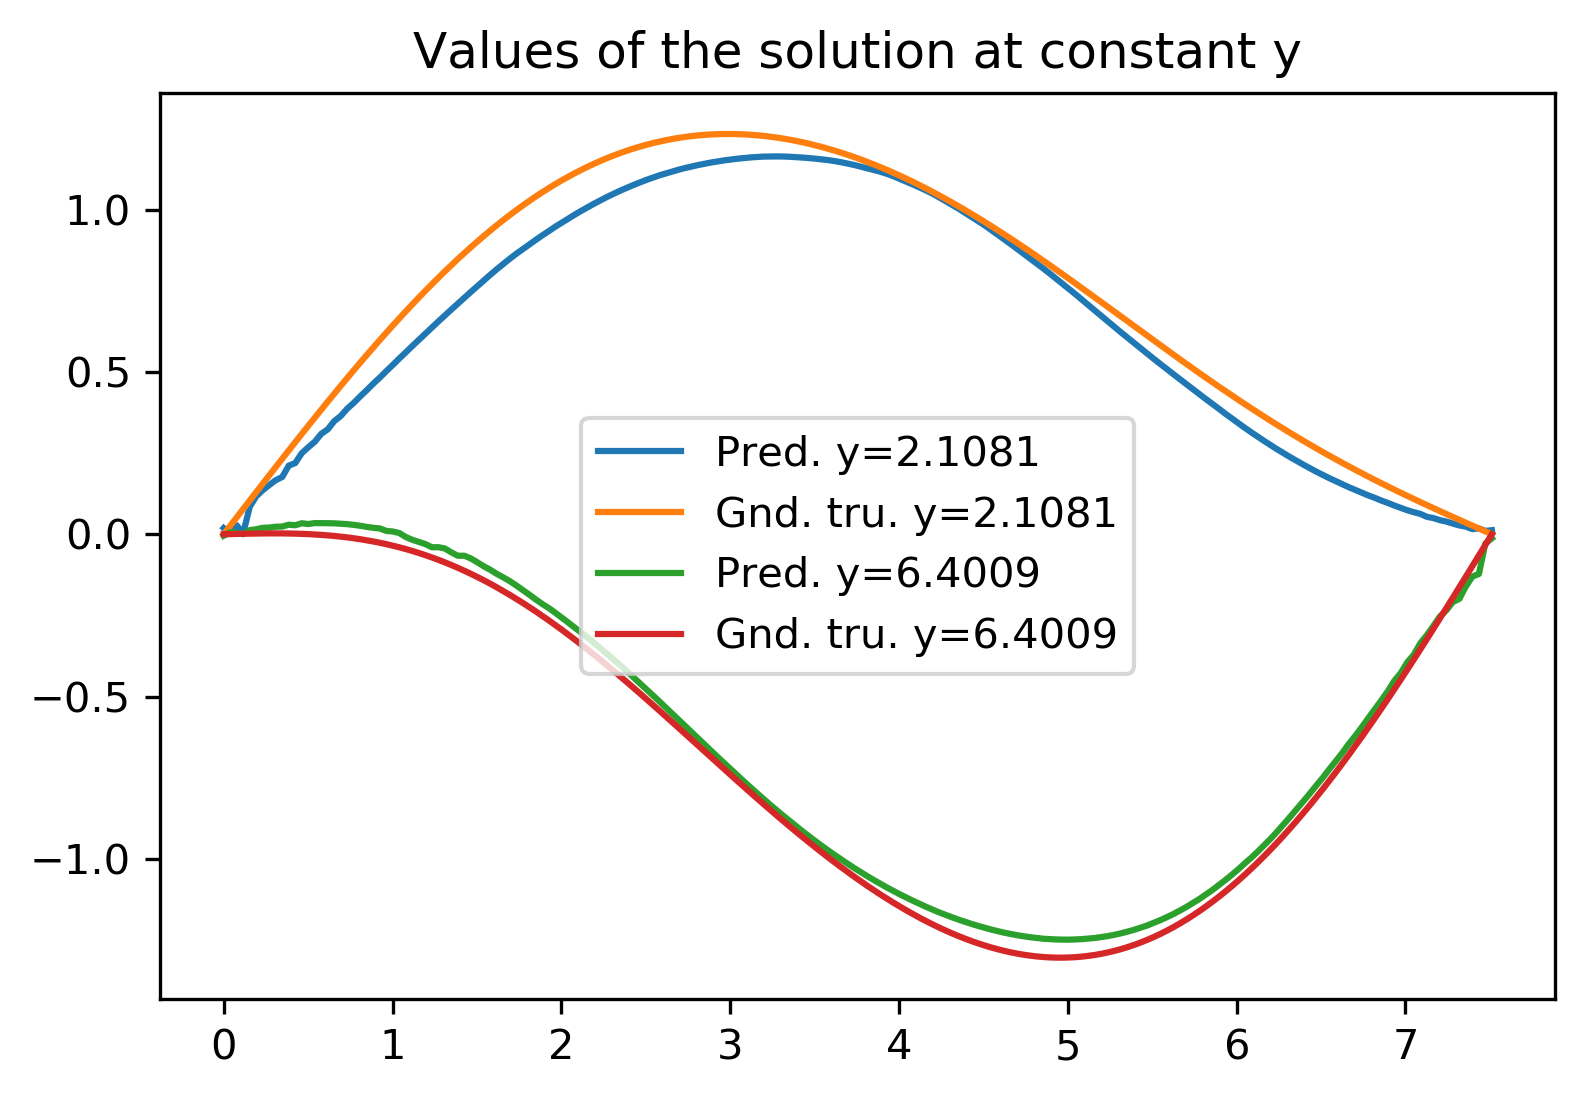

In [258]:
#Plots at constant y (change ypos variable to adjust the y values)
ypos = (soln.shape[-1]//4)
print(np.squeeze(pred[p_r,0,:,ypos]).shape)
plt.plot(x[:,0], pred[p_r,0,:,ypos], label = 'Pred. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Gnd. tru. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
ypos = (3*soln.shape[-1]//4)
plt.plot(x[:,0], pred[p_r,0,:,ypos], label = 'Pred. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Gnd. tru. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.legend()
plt.title('Values of the solution at constant y')

if saving:
    thisimage = 'consty'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(223,)


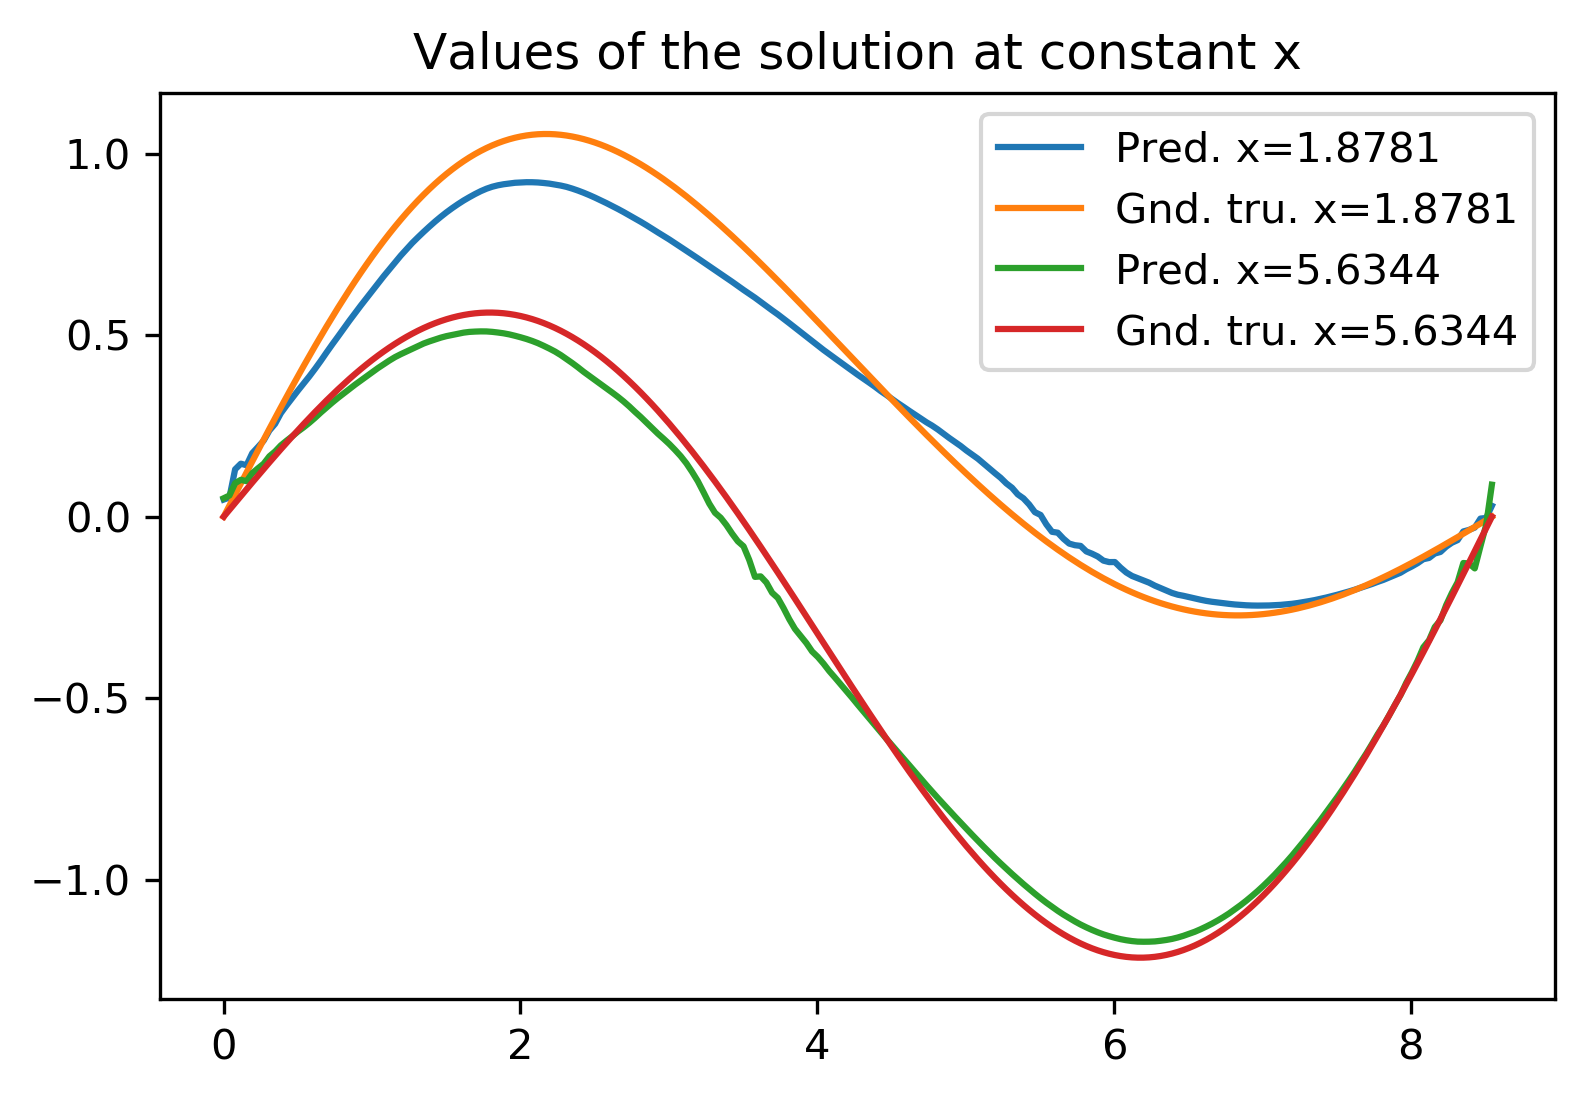

In [259]:
#Plots at constant x
xpos = (soln.shape[-2]//4)
print(np.squeeze(pred[p_r,0,xpos,:]).shape)
plt.plot(y[0,:], pred[p_r,0,xpos,:], label = 'Pred. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Gnd. tru. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
xpos = (3*soln.shape[-2]//4)
plt.plot(y[0,:], pred[p_r,0,xpos,:], label = 'Pred. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Gnd. tru. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.legend()
plt.title('Values of the solution at constant x')

if saving:
    thisimage = 'constx'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

Mean absolute % error: 14.878507614135742
Mean absolute error: 0.04155632108449936


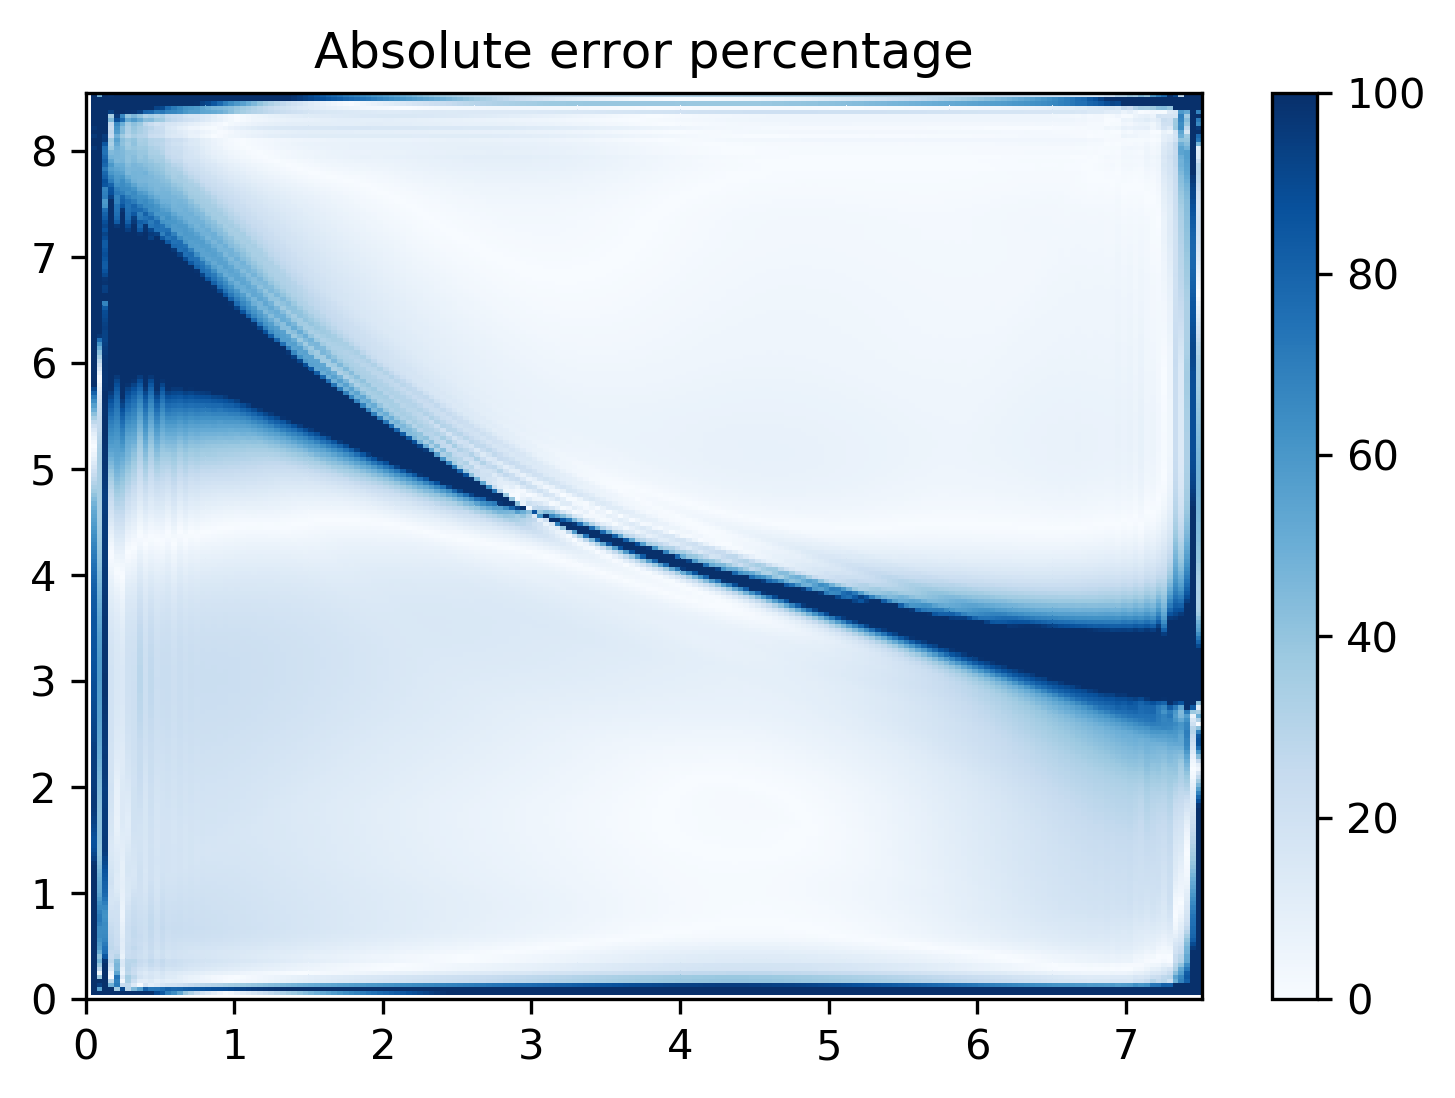

In [260]:
#Percentage error map plot
pred = mod(inp)
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = 100*tf.abs((pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))/tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))
z_min, z_max = 0,100
print('Mean absolute % error: ' + str(float(np.mean(np.array(z)[np.array(z) < 100]))))
print('Mean absolute error: ' + str(float(tf.reduce_mean(tf.keras.losses.mae(pred[p_r,0,...], soln[p_r,0,...])))))
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error percentage')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'percentageerrormap'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

0.04155632


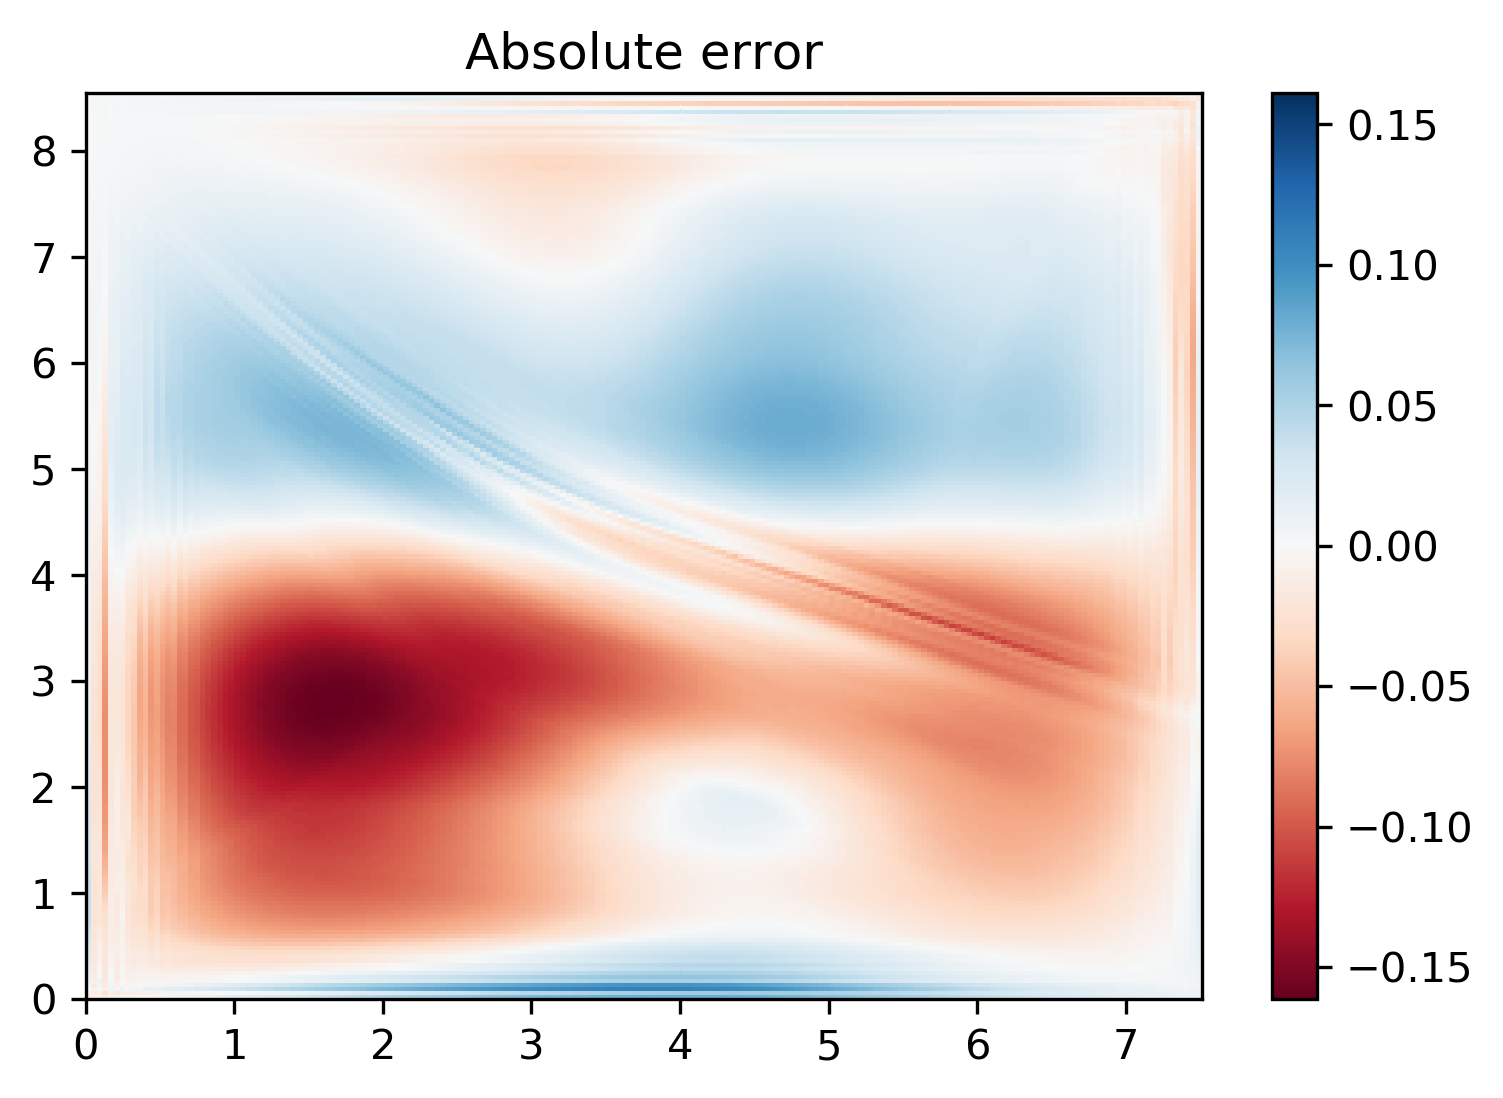

In [261]:
#Error map plot
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx())
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
print(np.mean(np.abs(z)))
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'errormap'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

In [ ]:
#Evaluate error statistics for 600 samples (can take long!)
from IPython.display import clear_output
rmses = []
maes = []
mapes = []
pgpb10s = []
nepochs = 60
roundtonearest = lambda x,base: base * round(x/base)
for k in range(nepochs):
    if k%5 == 0:
        progress = int(roundtonearest(k/nepochs,0.05)//0.05)
        clear_output()
        progressbar = ''.join(['['] + ['=' for s in range(progress-1)] + ['>'] + [' ' for s in range(20-progress)] + [']'])
        print(progressbar)
        
    inp600, soln600 = dg.__getitem__(10)
    pred600 = mod(inp600)
    rms = tf.sqrt(tf.reduce_mean((pred600 - tf.cast(soln600, tf.keras.backend.floatx()))**2))
    mae = tf.reduce_mean(tf.abs(pred600 - tf.cast(soln600, tf.keras.backend.floatx())))
    q = np.abs(pred600 - tf.cast(soln600, tf.keras.backend.floatx()))/np.abs(tf.cast(soln600, tf.keras.backend.floatx()))
    rmses.append(rms)
    maes.append(mae)
    mapes.append(100*float(tf.reduce_mean(q[q < 1])))
    pgpb10s.append(100*float(np.sum(q < 0.1)/np.prod(q.shape)))
print('Mean abs % error: ' + str(np.mean(mapes)))
print('% of gridpts with less than 10% error: ' + str(np.mean(pgpb10s)))
print('RMS error: ' + str(np.mean(rmses)))
print('MAE: ' + str(np.mean(maes)))